In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Importing tree-based classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# more
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [7]:
df= pd.read_csv("Base.csv")

In [8]:
fraud_vals = pd.DataFrame(df['fraud_bool'].value_counts())
print(fraud_vals)

   fraud_bool
0      988971
1       11029


In [9]:
fraud_vals.reset_index(inplace=True)
print(fraud_vals)

   index  fraud_bool
0      0      988971
1      1       11029


In [10]:
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]

print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


In [14]:
# Create a list of categorical features in the DataFrame new_df whose data type is `object`
categorical_features = [x for x in df.columns if df[x].dtypes == "O"]

print(categorical_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [15]:
# Convert categorical variables into dummy variables using one-hot encoding
new_df = pd.DataFrame(pd.get_dummies(df, prefix=categorical_features))

In [16]:
new_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,...,0,0,0,1,0,1,0,0,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,...,0,0,0,1,0,0,0,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,...,0,0,0,1,0,0,0,0,1,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,...,0,0,0,1,0,1,0,0,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,...,0,0,0,1,0,0,0,1,0,0


In [17]:
df_train = new_df[new_df["month"] < 6]
df_test = new_df[new_df["month"] >= 6]

In [18]:
# Separate the feature matrix and target variable
X = df_train.drop(['fraud_bool', 'device_fraud_count'], axis=1)
y = df_train['fraud_bool']

In [19]:
X_test = df_test.drop(['fraud_bool', 'device_fraud_count'], axis=1)
y_test = df_test['fraud_bool']

In [20]:
# Perform NearMiss undersampling to handle imbalanced data
print(f'Test dataset samples per class {Counter(y)}')

Test dataset samples per class Counter({0: 786838, 1: 8151})


In [25]:
# Define the NearMiss undersampling object with a sampling strategy of 0.1 and all available CPU cores
nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_nm))

Resampled dataset shape Counter({0: 81510, 1: 8151})


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.25, random_state=42, stratify=y_nm)

In [28]:
encoded_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]

In [38]:
# Initialize the model
XGB = XGBClassifier(random_state=0)

# Fit the model
XGB.fit(X_train, y_train)

# Predict on the test set
XGB_pred = XGB.predict(X_test)

# Evaluate the model
CM_XGB = confusion_matrix(y_test, XGB_pred)
CR_XGB = classification_report(y_test, XGB_pred)
fprXGB, recallXGB, thresholdXGB = roc_curve(y_test, XGB_pred)
AUC_XGB = auc(fprXGB, recallXGB)

print("Confusion Matrix:")
print(CM_XGB)
print("\nClassification Report:")
print(CR_XGB)
print("\nArea Under Curve (AUC):", AUC_XGB)

Confusion Matrix:
[[20133   245]
 [  757  1281]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     20378
           1       0.84      0.63      0.72      2038

    accuracy                           0.96     22416
   macro avg       0.90      0.81      0.85     22416
weighted avg       0.95      0.96      0.95     22416


Area Under Curve (AUC): 0.8082673197855911


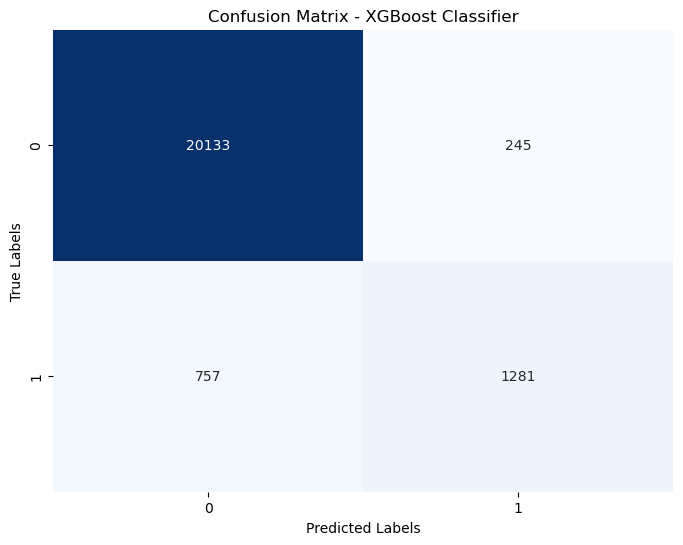

In [41]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(CM_XGB, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

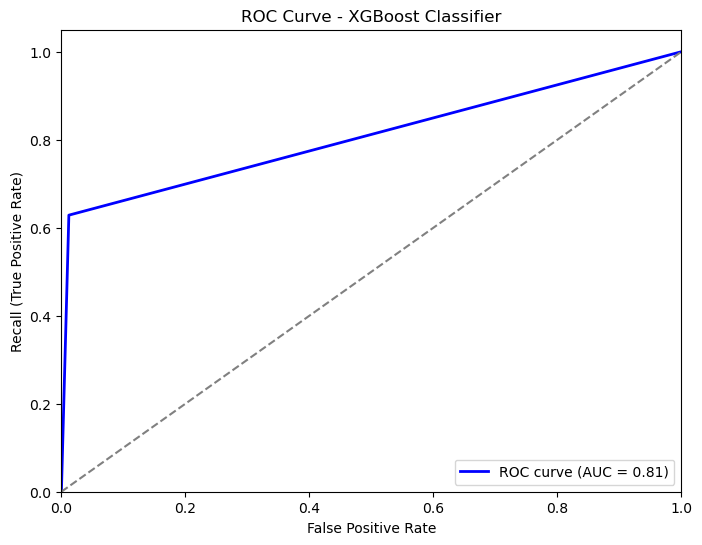

In [42]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprXGB, recallXGB, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % AUC_XGB)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (True Positive Rate)')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Initialize the RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

# Fit the model
RFC_fit = RFC.fit(X_train, y_train)

# Predict on the test set
RFC_pred = RFC.predict(X_test)

# Evaluate the model
CM_RFC = confusion_matrix(y_test, RFC_pred)
CR_RFC = classification_report(y_test, RFC_pred)
fprRFC, recallRFC, thresholdRFC = roc_curve(y_test, RFC_pred)
AUC_RFC = auc(fprRFC, recallRFC)

# Display the results
print("Confusion Matrix:")
print(CM_RFC)
print("\nClassification Report:")
print(CR_RFC)
print("\nArea Under Curve (AUC):", AUC_RFC)

Confusion Matrix:
[[20281    97]
 [ 1273   765]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20378
           1       0.89      0.38      0.53      2038

    accuracy                           0.94     22416
   macro avg       0.91      0.69      0.75     22416
weighted avg       0.94      0.94      0.93     22416


Area Under Curve (AUC): 0.6853039862593066


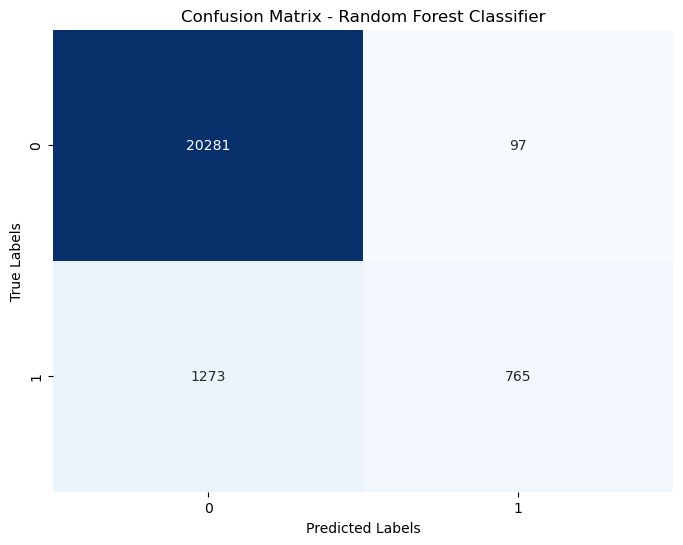

In [47]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(CM_RFC, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

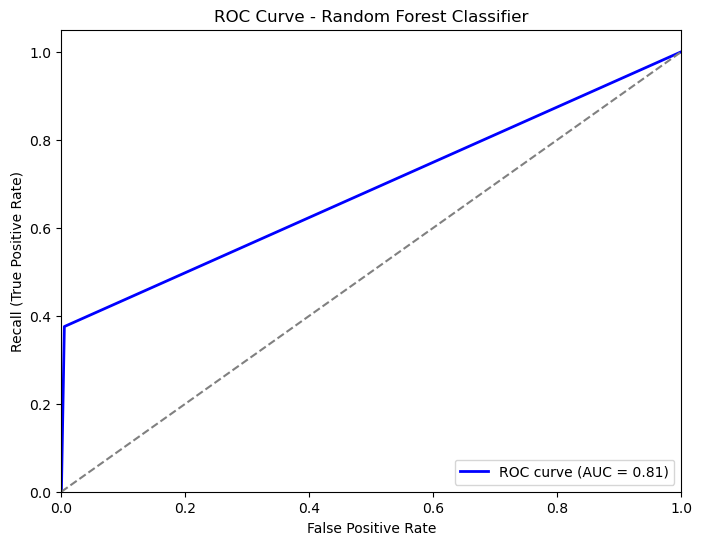

In [48]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprRFC, recallRFC, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % AUC_XGB)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (True Positive Rate)')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Initialize the DecisionTreeClassifier
DTC = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Fit the model
DTC_fit = DTC.fit(X_train, y_train)

# Predict on the test set
DTC_pred = DTC.predict(X_test)

# Evaluate the model
CM_DTC = confusion_matrix(y_test, DTC_pred)
CR_DTC = classification_report(y_test, DTC_pred)
fprDTC, recallDTC, thresholdDTC = roc_curve(y_test, DTC_pred)
AUC_DTC = auc(fprDTC, recallDTC)

# Display the results
print("Confusion Matrix:")
print(CM_DTC)
print("\nClassification Report:")
print(CR_DTC)
print("\nArea Under Curve (AUC):", AUC_DTC)

Confusion Matrix:
[[19404   974]
 [ 1128   910]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20378
           1       0.48      0.45      0.46      2038

    accuracy                           0.91     22416
   macro avg       0.71      0.70      0.71     22416
weighted avg       0.90      0.91      0.90     22416


Area Under Curve (AUC): 0.6993597744532171


In [44]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Initialize the LightGBM Classifier
LGBM = lgb.LGBMClassifier(class_weight='balanced', random_state=0)

# Fit the model
LGBM_fit = LGBM.fit(X_train, y_train)

# Predict on the test set
LGBM_pred = LGBM.predict(X_test)

# Evaluate the model
CM_LGBM = confusion_matrix(y_test, LGBM_pred)
CR_LGBM = classification_report(y_test, LGBM_pred)
fprLGBM, recallLGBM, thresholdLGBM = roc_curve(y_test, LGBM_pred)
AUC_LGBM = auc(fprLGBM, recallLGBM)

# Display the results
print("Confusion Matrix:")
print(CM_LGBM)
print("\nClassification Report:")
print(CR_LGBM)
print("\nArea Under Curve (AUC):", AUC_LGBM)

Confusion Matrix:
[[18605  1773]
 [  309  1729]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     20378
           1       0.49      0.85      0.62      2038

    accuracy                           0.91     22416
   macro avg       0.74      0.88      0.79     22416
weighted avg       0.94      0.91      0.92     22416


Area Under Curve (AUC): 0.8806875855940006
